In [77]:
import datetime as dt
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate

from IPython import display
from matplotlib.animation import FuncAnimation
from operator import attrgetter
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

# plt.ioff();

%matplotlib inline

# 1. Download and preprocess COVID data on Russia

In [2]:
# https://ourworldindata.org/coronavirus references owid/covid-19-data GitHub repo.
# So let's download directly file from repo, unless it already exists.
! wget -nc https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv

df = pd.read_csv('./owid-covid-data.csv')

File ‘owid-covid-data.csv’ already there; not retrieving.



In [3]:
def get_data_for_region(df, location, min_total_cases):
    # this query should also exclude rows with NaN total_cases
    df = df.query(f'location == "{location}" and total_cases >= {min_total_cases}')
    assert df['date'].is_monotonic, 'Rows for location {location} are not monotonic by date'

    min_date = dt.date.fromisoformat(df['date'].iloc[0])
    dates = df['date'].apply(dt.date.fromisoformat)
    return min_date, (dates - min_date).apply(attrgetter('days')).values, df['total_cases'].values


# min_total_cases=3 for Russia is equivalent to min_date=2020-03-03
min_date, X, y = get_data_for_region(df, 'Russia', min_total_cases=3)
assert min_date == dt.date(2020, 3, 3)

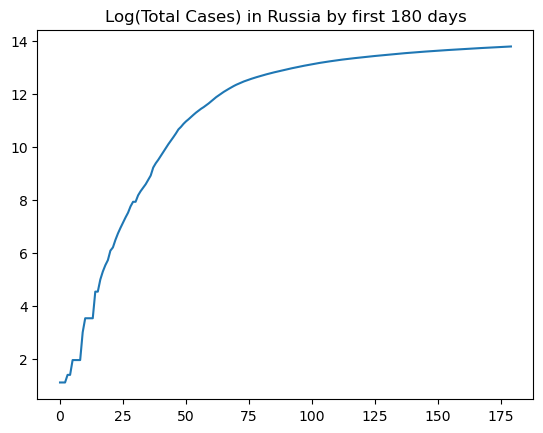

In [4]:
SHOW_FIRST_DAYS = 180

plt.title(f'Log(Total Cases) in Russia by first {SHOW_FIRST_DAYS} days')
plt.plot(np.arange(SHOW_FIRST_DAYS), np.log(y[:SHOW_FIRST_DAYS]));

In [113]:
TRAIN_FIRST_DAYS = 50

X_train, X_test = X[:TRAIN_FIRST_DAYS].reshape(-1, 1), X[TRAIN_FIRST_DAYS:].reshape(-1, 1)
y_train, y_test = y[:TRAIN_FIRST_DAYS], y[TRAIN_FIRST_DAYS:]

In [6]:
def fit_linear_regression_weights(X, y):
    linreg = LinearRegression().fit(X, y)
    return linreg.intercept_, linreg.coef_[0]


def predict(w, X):
    return w[1] * X + w[0]

# 2. Explore exponential models

## 2a. Train linear regression

Weights are (1.1934192756385702, 0.21410636658252818)


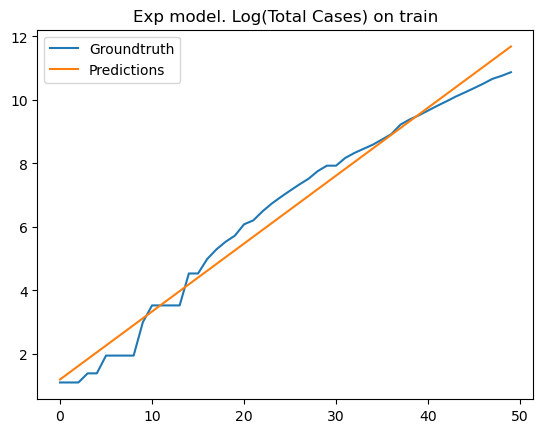

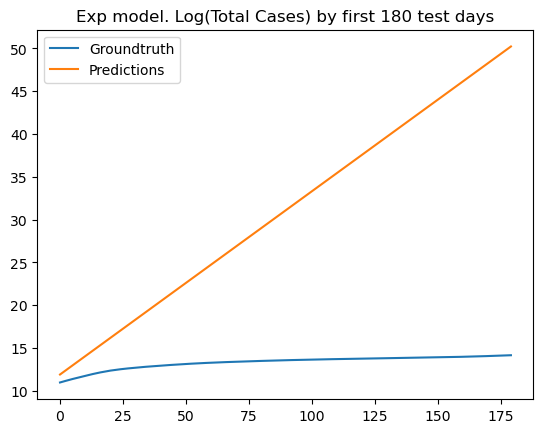

In [7]:
y_exp_train, y_exp_test = np.log(y_train), np.log(y_test)

w_exp = fit_linear_regression_weights(X_train, y_exp_train)
pred_exp_train = predict(w_exp, X_train)
pred_exp_test = predict(w_exp, X_test)

print('Weights are', w_exp)

plt.title('Exp model. Log(Total Cases) on train')
plt.plot(np.arange(y_exp_train.shape[0]), y_exp_train, label='Groundtruth')
plt.plot(np.arange(pred_exp_train.shape[0]), pred_exp_train, label='Predictions')
plt.legend()
plt.show()

plt.title(f'Exp model. Log(Total Cases) by first {SHOW_FIRST_DAYS} test days')
plt.plot(np.arange(SHOW_FIRST_DAYS), y_exp_test[:SHOW_FIRST_DAYS], label='Groundtruth')
plt.plot(np.arange(SHOW_FIRST_DAYS), pred_exp_test[:SHOW_FIRST_DAYS], label='Predictions')
plt.legend();

## 2b. Bayess regression

In [8]:
sigma_exp_train = np.std(y_exp_train - pred_exp_train)
print(f'Estimated sigma of posterior distribution is {sigma_exp_train}')

Estimated sigma of posterior distribution is 4.392653043878289


In [214]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.concatenate(([1,], x.reshape(-1))).reshape(1, -1)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )    
    return mu_n, sigma_n


def estimate_posterior_distribution(X, y, mu_prior, sigma_prior, sigma_noise):
    cur_mu, cur_sigma = mu_prior, sigma_prior
    mu_sigmas = [(cur_mu, cur_sigma)]
    for xi, yi in zip(X, y):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, xi, yi, sigma_noise)
        mu_sigmas.append((cur_mu, cur_sigma))
    return mu_sigmas

mu_prior, sigma_prior = np.zeros(2), 512 * np.identity(2)
mu_sigmas = estimate_posterior_distribution(X_train, y_exp_train, mu_prior, sigma_prior, sigma_noise=sigma_exp_train)
print('Mu', mu_sigmas[-1][0])
print('Sigma', mu_sigmas[-1][1], sep='\n')

Mu [1.18995618 0.21421111]
Sigma
[[ 1.49385573 -0.04526831]
 [-0.04526831  0.00184908]]


In [135]:
def animate_heatmap(mu_sigmas, delta=5, N = 512):
    fig, ax = plt.subplots()
    ax.set_xlim(-delta, delta)
    ax.set_ylim(-delta, delta)
    
    X = np.linspace(-delta, delta, N)
    Y = np.linspace(-delta, delta, N)
    X, Y = np.meshgrid(X, Y)


    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    def animate(i):
        mu, sigma = mu_sigmas[i]
        Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)
        return ax.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    
    anim = FuncAnimation(fig, animate, len(mu_sigmas), interval=200)
    display.display(display.HTML(anim.to_html5_video()))
    plt.close()

In [43]:
%%time

animate_heatmap(mu_sigmas)

CPU times: user 5min 52s, sys: 296 ms, total: 5min 52s
Wall time: 5min 52s


# 2c. Sample weights & predictions distributions

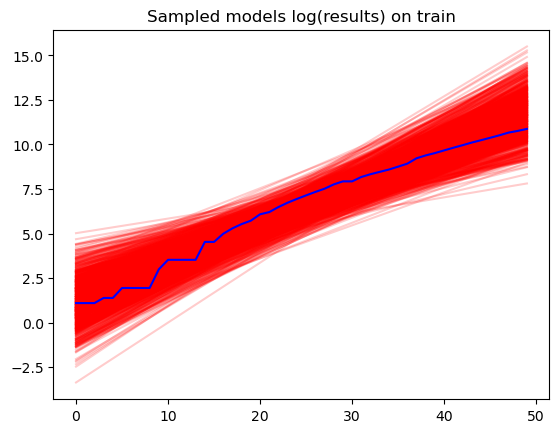

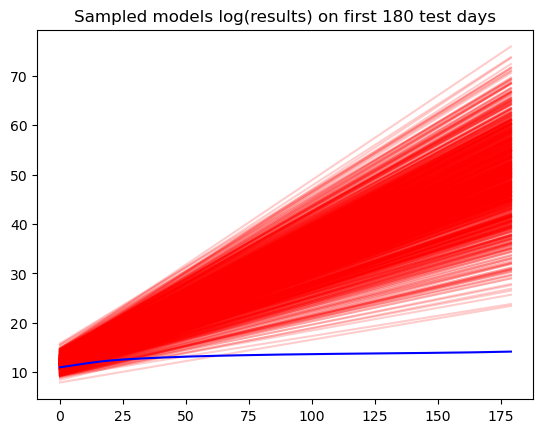

In [72]:
def plot_models(w, X, y, label): 
    plt.title(f'Sampled models log(results) on {label}')
    for wi in w:
        plt.plot(predict(wi, X), color='red', alpha=0.2)
    plt.plot(y, color='blue')
    plt.show()

n_samples = 1024
w_exp_sampled = np.random.multivariate_normal(mu_sigmas[-1][0], mu_sigmas[-1][1], n_samples)
plot_models(w_exp_sampled, X_train, y_exp_train, 'train')
plot_models(w_exp_sampled, X_test[:SHOW_FIRST_DAYS], y_exp_test[:SHOW_FIRST_DAYS], f'first {SHOW_FIRST_DAYS} test days')

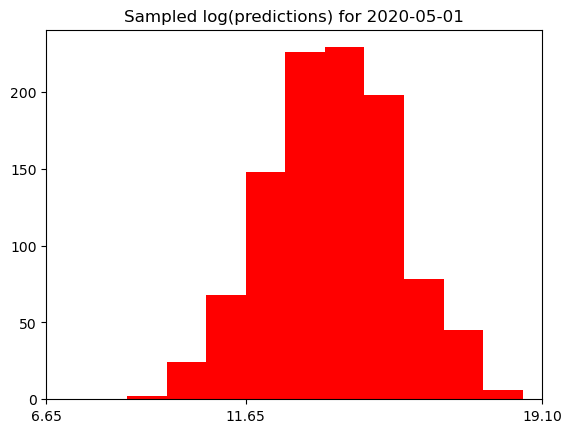

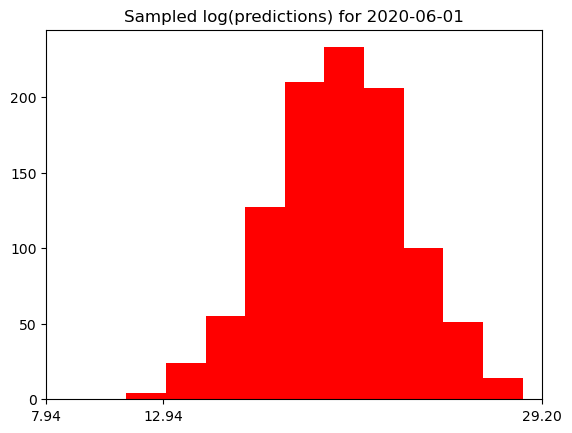

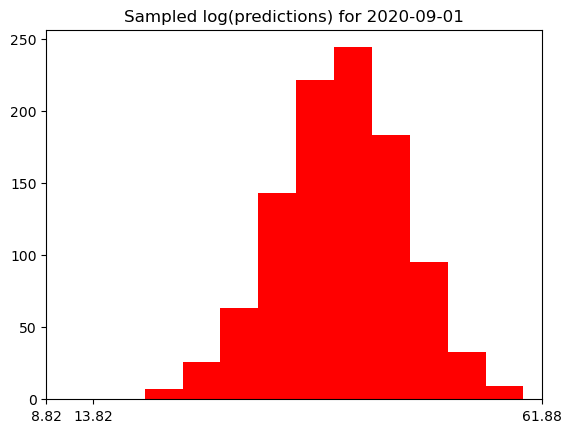

In [76]:
def plot_pred_dist(w, X, y, i, label):
    plt.title(f'Sampled log(predictions) for {label}')
    plt.hist([float(predict(wi, X[i])) for wi in w], color='red')
    plt.xlim(min(plt.xlim()[0], y[i] - 5), max(plt.xlim()[1], y[i] + 5))
    plt.xticks([plt.xlim()[0], y[i], plt.xlim()[1]])
    plt.show()
    
for month in (5, 6, 9):
    date = dt.date(2020, month, 1)
    idx = (date - min_date).days - TRAIN_FIRST_DAYS
    plot_pred_dist(w_exp_sampled, X_test, y_exp_test, idx, date.isoformat())

# 3. Explore sigmoid models

## 3a. Train linear regression

Weights are (-0.5156038831027878, 0.23168264196196103, -0.0007596731666422036)


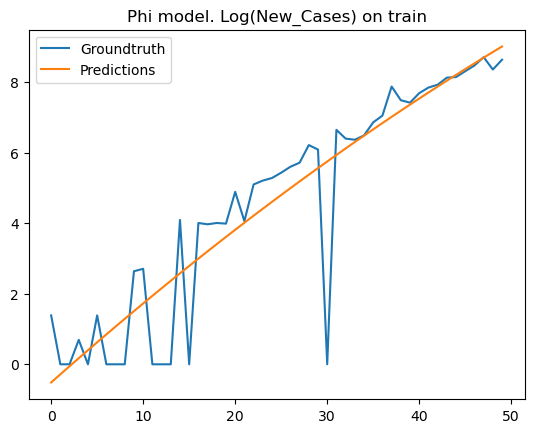

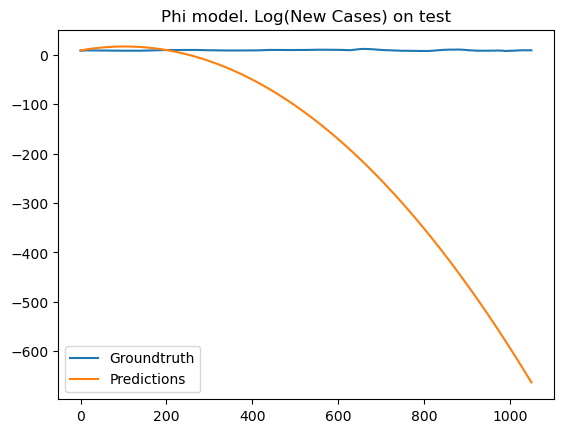

In [212]:
X_phi_train = np.concatenate((X_train, X_train ** 2), axis=1)
X_phi_test = np.concatenate((X_test, X_test ** 2), axis=1)
y_phi_train = np.log(np.concatenate(([3], np.ediff1d(y_train))) + 1)
y_phi_test = np.log(np.concatenate(([y_test[0] - y_train[-1]], np.ediff1d(y_test))) + 1)


def fit_linear_regression_phi_weights(X, y):
    linreg = LinearRegression().fit(X, y)
    return linreg.intercept_, linreg.coef_[0], linreg.coef_[1]


def phi_predict(w, X):
    return w[2] * X[:,1] + w[1] * X[:,0] + w[0]


w_phi = fit_linear_regression_phi_weights(X_phi_train, y_phi_train)
pred_phi_train = phi_predict(w_phi, X_phi_train)
pred_phi_test = phi_predict(w_phi, X_phi_test)

print('Weights are', w_phi)

plt.title('Phi model. Log(New_Cases) on train')
plt.plot(np.arange(y_phi_train.shape[0]), y_phi_train, label='Groundtruth')
plt.plot(np.arange(pred_phi_train.shape[0]), pred_phi_train, label='Predictions')
plt.legend()
plt.show()

plt.title(f'Phi model. Log(New Cases) on test')
plt.plot(np.arange(y_phi_test.shape[0]), y_phi_test, label='Groundtruth')
plt.plot(np.arange(y_phi_test.shape[0]), pred_phi_test, label='Predictions')
plt.legend();

## 3b. Bayes regression

In [213]:
sigma_phi_train = np.std(y_phi_train - pred_phi_train)
print(f'Estimated sigma of posterior distribution is {sigma_phi_train}')

Estimated sigma of posterior distribution is 1.2392520478214657


In [216]:
mu_prior, sigma_prior = np.zeros(3), 512 * np.identity(3)
mu_sigmas = estimate_posterior_distribution(X_phi_train, y_phi_train, mu_prior, sigma_prior, sigma_noise=sigma_exp_train)
print('Mu', mu_sigmas[-1][0])
print('Sigma', mu_sigmas[-1][1], sep='\n')

Mu [-0.51227545  0.23141027 -0.00075506]
Sigma
[[ 3.18937414e+00 -2.57679537e-01  4.33800694e-03]
 [-2.57679537e-01  2.84595408e-02 -5.43457009e-04]
 [ 4.33800694e-03 -5.43457009e-04  1.10988499e-05]]


## 3c. Sample weights & predictions distributions

/home/bgvsk/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


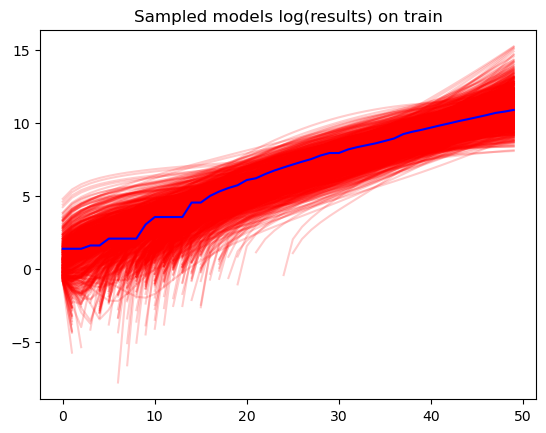

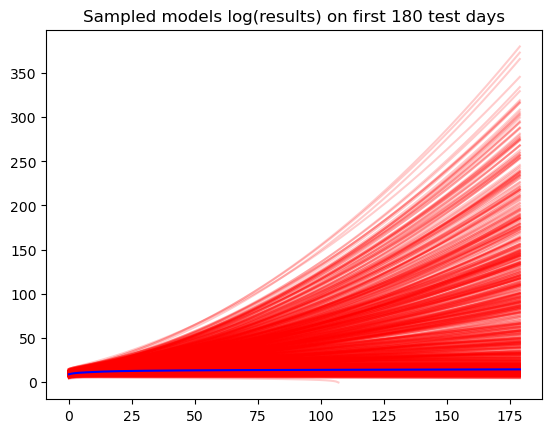

In [237]:
def log_phi(y):
    return np.log(1 + np.cumsum(np.exp(y) - 1))

def plot_models(w, X, y, label): 
    plt.title(f'Sampled models log(results) on {label}')
    for wi in w:
        plt.plot(log_phi(phi_predict(wi, X)), color='red', alpha=0.2)
    plt.plot(log_phi(y), color='blue')
    plt.show()

n_samples = 1024
w_phi_sampled = np.random.multivariate_normal(mu_sigmas[-1][0], mu_sigmas[-1][1], n_samples)
plot_models(w_phi_sampled, X_phi_train, y_phi_train, 'train')
plot_models(w_phi_sampled, X_phi_test[:SHOW_FIRST_DAYS], y_phi_test[:SHOW_FIRST_DAYS], f'first {SHOW_FIRST_DAYS} test days')

2020-05-01 10th 5.858559511334468 90th 15.28378998175816 true [8.9789126]


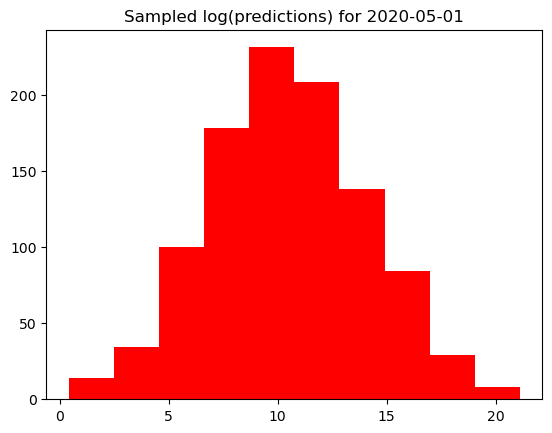

In [238]:
def plot_pred_dist(w, X, y, i, label):
    plt.title(f'Sampled log(predictions) for {label}')
    vals = [float(log_phi(phi_predict(wi, X[[i]]))) for wi in w]
    print(label, '10th', np.percentile(vals, 10), '90th', np.percentile(vals, 90), 'true', phi(y[i]))
    plt.hist(vals, color='red')
    plt.show()
    
date = dt.date(2020, 5, 1)
idx = (date - min_date).days - TRAIN_FIRST_DAYS
plot_pred_dist(w_phi_sampled, X_phi_test, y_phi_test, idx, date.isoformat())

True value is above 10th percentile and below 90th. However spread is enormous!

## 5. Conclusions

On 50th day there's likely to be no insight in $total\_cases$ time series on when or how exponential growth
could possibly fade out.